In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils

In [3]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=10)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr", type=float, default=2e-4)
parser.add_argument("--nch_g", type=int, default=128)
parser.add_argument("--nch_d", type=int, default=128)
parser.add_argument("--z_dim", type=int, default=100) # noize dimension
parser.add_argument("--beta1", type=float, default=0.5)
parser.add_argument("--c_lower", type=float, default=-0.01)   # weight clipping
parser.add_argument("--c_upper", type=float, default=0.01)   # weight clipping
parser.add_argument("--n_critic", type=int, default=5)
opt = parser.parse_args(args=[])

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, ngf=128, nc=1):   # nc=1 for black-and-white images
        super().__init__()
        self.convt1 = self.conv_trans_layers(z_dim, 4*ngf, 3, 1, 0)
        self.convt2 = self.conv_trans_layers(4*ngf, 2*ngf, 3, 2, 0)
        self.convt3 = self.conv_trans_layers(2*ngf, ngf, 4, 2, 1)
        self.convt4 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            nn.Tanh()
        )

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                               stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return net

    def forward(self, x):
        out = self.convt1(x)
        out = self.convt2(out)
        out = self.convt3(out)
        out = self.convt4(out)
        return out


In [5]:
x = torch.randn([32, 100, 1, 1])
netG = Generator(z_dim=opt.z_dim, ngf=opt.nch_g)
out = netG(x)

In [6]:
out.size()

torch.Size([32, 1, 28, 28])

In [7]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=128):
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf, has_batch_norm=False)
        self.conv2 = self.conv_layers(ndf, 2*ndf)
        self.conv3 = self.conv_layers(2*ndf, 4*ndf, 3, 2, 0)
        self.conv4 = nn.Sequential(
            nn.Conv2d(4*ndf, 1, 3, 1, 0),
            nn.Sigmoid()
        )

    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=2,
                    has_batch_norm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                      padding, bias=False)
        ]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        net = nn.Sequential(*layers)
        return net

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        return out


In [8]:
x = torch.randn(32, 1, 28, 28)
netD = Discriminator(nc=1, ndf=opt.nch_d)
out = netD(x)

In [9]:
out.size()

torch.Size([32, 1, 1, 1])

In [10]:
def weights_init(m):
    # m means model
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)   # initialize using normal distribution
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)   # initialize using normal distribution
        nn.init.constant_(m.bias.data, 0)   # initialize


In [11]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [12]:
import os

In [13]:
dir_path = "/content/drive/MyDrive/result"
os.makedirs(dir_path, exist_ok=True)

In [14]:
dataset = dset.MNIST(root="/content/drive/MyDrive/data/", download=False,
                     train=True, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=opt.batch_size, shuffle=True)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
netG = Generator(z_dim=opt.z_dim, ngf=opt.nch_g).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(nc=1, ndf=opt.nch_d).to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=

In [17]:
criterion = nn.BCELoss()

optimizerG = optim.RMSprop(netG.parameters(), lr=opt.lr)
optimizerD = optim.RMSprop(netD.parameters(), lr=opt.lr)

In [18]:
def save_params(file_path, epoch, netD, netG):
    torch.save(
        netG.state_dict(),
        file_path + "/g_{:04d}.pth".format(epoch)
    )
    torch.save(
        netD.state_dict(),
        file_path + "/d_{:04d}.pth".format(epoch)
    )


In [19]:
model_name = "WGAN"
f_path_result = "/content/drive/MyDrive/result/{}".format(model_name)
f_path_params = "/content/drive/MyDrive/params/{}".format(model_name)

os.makedirs(f_path_result, exist_ok=True)
os.makedirs(f_path_params, exist_ok=True)

100%|██████████| 938/938 [00:23<00:00, 39.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, lossD: -0.026017515103954243, lossG: -0.48262382929386105


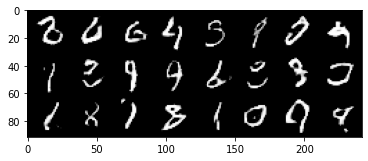

100%|██████████| 938/938 [00:23<00:00, 39.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1, lossD: -0.02485287936130312, lossG: -0.48395128344803223


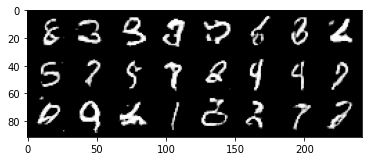

100%|██████████| 938/938 [00:24<00:00, 39.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2, lossD: -0.024146156492772134, lossG: -0.4819210042386675


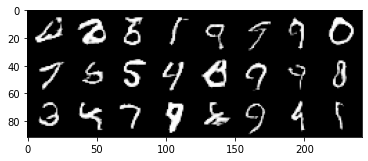

100%|██████████| 938/938 [00:24<00:00, 38.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3, lossD: -0.023140063672177573, lossG: -0.4833658305185436


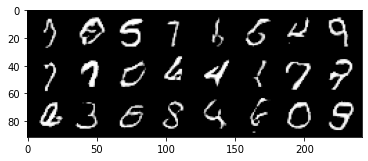

100%|██████████| 938/938 [00:24<00:00, 38.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4, lossD: -0.02278645120577009, lossG: -0.48054535226272876


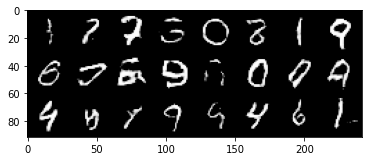

100%|██████████| 938/938 [00:24<00:00, 38.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 5, lossD: -0.022436041218131336, lossG: -0.47960663041961726


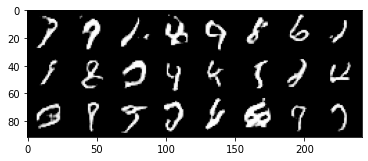

100%|██████████| 938/938 [00:23<00:00, 39.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 6, lossD: -0.021518964090072777, lossG: -0.4820947377984203


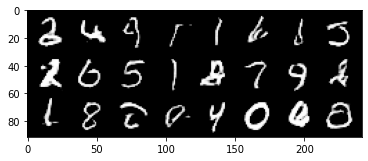

100%|██████████| 938/938 [00:24<00:00, 38.83it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 7, lossD: -0.021302861381949645, lossG: -0.48133562575144045


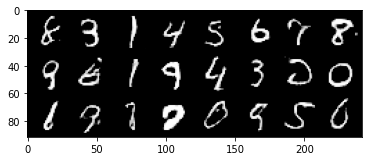

100%|██████████| 938/938 [00:24<00:00, 38.83it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 8, lossD: -0.0205779017161713, lossG: -0.48544320880350017


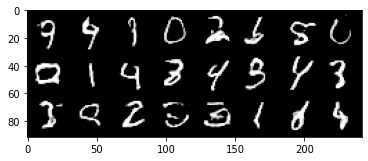

100%|██████████| 938/938 [00:24<00:00, 38.81it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 9, lossD: -0.020376949358596477, lossG: -0.4797821313396954


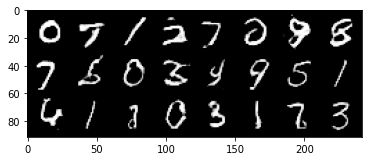

In [32]:
lossesD = []
lossesG = []
raw_lossesD = []
raw_lossesG = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0
    running_lossG = 0.0
    for i, (real_imgs, labels) in enumerate(tqdm.tqdm(dataloader, position = 0)):
        """
        clip weight of discrimator
        """
        for p in netD.parameters():
            p.data.clamp_(opt.c_lower, opt.c_upper)
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)
 
        shape = (batch_size, 1, 1, 1)
        labels_real = torch.ones(shape).to(device)
        labels_fake = torch.zeros(shape).to(device)
 
        """train Discriminator"""
        netD.zero_grad()
        output = netD(real_imgs)
        lossD_real = -torch.mean(output)
        #lossD_real = criterion(output, labels_real)
 
        fake_imgs = netG(noise)
        output = netD(fake_imgs.detach())
        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(output)
 
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        if i % opt.n_critic == 0:
 
            netG.zero_grad()
            output = netD(fake_imgs)
            #lossG = criterion(output, labels_real)
            lossG = -torch.mean(output)
            lossG.backward()
            optimizerG.step()
            raw_lossesG.append(lossG.item())
 
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        raw_lossesD.append(lossD.item())
 
    running_lossD /= len(dataloader)
    running_lossG /= len(dataloader)
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)
    print('epoch: {}, lossD: {}, lossG: {}'.format(epoch, running_lossD, running_lossG))
 
    # show fake imgs
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach())
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()
 
    # save imgs and parameters
    vutils.save_image(fake_imgs, f_path_result + '/{}.jpg'.format(epoch))
    save_params(f_path_params, epoch, netD, netG)

In [33]:
torch.__version__

'1.10.0+cu111'

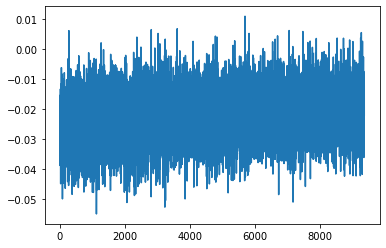

In [34]:
plt.plot(raw_lossesD)

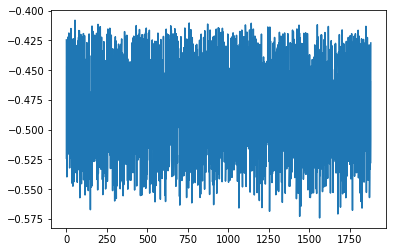

In [35]:
plt.plot(raw_lossesG)

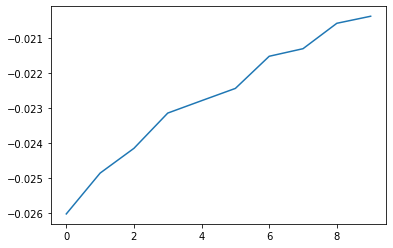

In [36]:
plt.plot(lossesD)

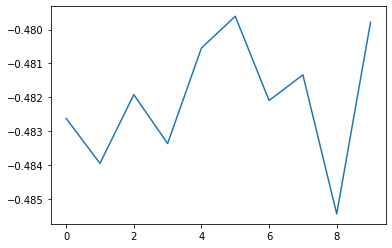

In [37]:
plt.plot(lossesG)